In [4]:
!megadl "https://mega.nz/file/VzZGhaxS#aRSjaOgyI_AMRtuWwIk16XtWBhi4oG8CApWdXB89NRA" --path /content

Downloaded madverse_data.zip


In [5]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/madverse_preprocessed_data.csv  
  inflating: data/ocr_ads_cleaned.csv  


In [6]:
!unzip madverse_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_7.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_36.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_30.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_53.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_11.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_23.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_46.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_6.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_2.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_32.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_3.jpg  
  inflating: madverse_data/OnlineAds/travel/travel_connect/Yatra/Yatra_13

## Imports


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.models import mobilenet_v2
from PIL import Image

from transformers import DistilBertTokenizerFast, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Configuration


In [26]:
from config import CHECKPOINT_DIR, DATA_ROOT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 15

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

## Load Dataset


In [27]:
df = pd.read_csv(f"{DATA_ROOT}/ocr_ads_cleaned.csv")

# Drop rows with missing or empty required fields
df = df.dropna(subset=["image_path", "filtered_text", "label"])

# Also remove rows where filtered_text is empty string
df = df[df["filtered_text"].str.strip() != ""].reset_index(drop=True)

df.head()

,image_path,slogan_text,label,clean_text,filtered_text
0,madverse_data/OnlineAds/baby_products/baby_ess...,chicco baby moments F0 R EVERYDAY MOMENTS 0 F ...,baby_products,chicco moments everyday moments parabens free ...,chicco moments everyday moments parabens free
1,madverse_data/OnlineAds/baby_products/baby_ess...,"""No language can express the power and beauty,...",baby_products,language can express the power and beauty and ...,language can express the power and beauty and ...
2,madverse_data/OnlineAds/baby_products/baby_ess...,(chicco) Baby Care for New-age Parents like Yo...,baby_products,chicco care for new age parents like you momen...,chicco care for new age parents like you momen...
3,madverse_data/OnlineAds/baby_products/baby_ess...,#PARTNER iN PARENting Complete Protection for ...,baby_products,partner parenting complete protection for your...,partner complete protection for your minutes e...
4,madverse_data/OnlineAds/baby_products/baby_ess...,C (chicco) MOMENT OF DeeP CLEANSING AND NOURIS...,baby_products,chicco moment deep cleansing and nourishment c...,chicco moment deep cleansing and nourishment c...


## Encode Labels


In [28]:
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"])

NUM_CLASSES = len(le.classes_)
print("Classes:", le.classes_)

Classes: ['baby_products' 'body_wear' 'cosmetics' 'drinks' 'electronics'
 'financial_institutions' 'food' 'home_essentials' 'sports' 'travel'
 'vehicles']


## Train Test Split

In [29]:
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label_id"], random_state=42
)

## Image Transformations


In [30]:
img_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

## Save Model Utility

In [31]:
def save_model(
    model,
    optimizer,
    epoch,
    num_classes,
    le,
    filename,
    train_losses,
    test_losses,
    text_model_str=None,
    image_encoder_str=None,
    text_encoder_str=None,
):
    data = {
        "model_state_dict": model.state_dict(),
        "num_classes": num_classes,
        "label_classes": le.classes_.tolist(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "test_losses": test_losses,
    }

    if text_model_str:
        data["text_model"] = text_model_str

    if image_encoder_str:
        data["image_encoder"] = image_encoder_str

    if text_encoder_str:
        data["text_encoder"] = text_encoder_str

    torch.save(data, filename)

    print(f"Saved model to {filename}")

## Training Utilities


In [80]:
def train_epoch(model, loader, optimizer, scaler, criterion, device, mode="image"):
    model.train()
    correct, total_loss = 0, 0

    for batch in loader:
        # x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # with torch.amp.autocast(device):
        #     out = model(x)
        #     loss = criterion(out, y)

        if mode == "image":
            x, y = batch
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with torch.amp.autocast(device):
                out = model(x)

        elif mode == "text":
            input_ids, attention_mask, y = batch
            input_ids = input_ids.to(device, non_blocking=True)
            attention_mask = attention_mask.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            with torch.amp.autocast(device):
                embeddings = distilbert(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                ).last_hidden_state[:, 0, :]
                out = model(embeddings)
        loss = criterion(out, y)


        # Scale the loss and do backward
        scaler.scale(loss).backward()
        # Step optimizer with scaled gradients
        scaler.step(optimizer)
        # Update the scaler for next iteration
        scaler.update()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


def eval_epoch(model, loader, criterion, device, mode="image"):
    model.eval()
    correct, total_loss = 0, 0

    with torch.no_grad():
        for batch in loader:
            if mode == "image":
                x, y = batch
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                with torch.amp.autocast("cuda"):
                    out = model(x)

            elif mode == "text":
                input_ids, attention_mask, y = batch
                input_ids = input_ids.to(device, non_blocking=True)
                attention_mask = attention_mask.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                with torch.amp.autocast("cuda"):
                    text_emb = distilbert(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    ).last_hidden_state[:, 0, :]
                    out = model(text_emb)

            # images, labels = images.to(device), labels.to(device)
            # out = model(images)
            correct += (out.argmax(1) == y).sum().item()
            loss = criterion(out, y)
            total_loss += loss.item()

    return total_loss / len(loader), correct / len(loader.dataset)


def plot_training_curves(train_losses, val_losses=None, title="Training Progress"):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, "b-", label="Training Loss", linewidth=2)
    if val_losses:
        plt.plot(epochs, val_losses, "r-", label="Validation Loss", linewidth=2)

    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Image-Only Model (MobileNetV2)


## Image Dataset


In [39]:
class ImageDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        img = img_transform(img)
        label = row["label_id"]
        return img, label

## MobileNetV2 Image Model


In [40]:
class ImageModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = mobilenet_v2(weights="IMAGENET1K_V1")
        self.backbone.classifier = nn.Identity()  # 1280-d
        # self.classifier = nn.Linear(1280, num_classes)
        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),    # Stabilizes learning
            nn.ReLU(),
            nn.Dropout(0.3),  # Prevent overfitting
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),    # Stabilizes learning
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        feat = self.backbone(x)
        return self.classifier(feat)

## Train Image-Only Model


In [42]:
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "mobilenetv2_image_model.pth")

train_loader = DataLoader(ImageDataset(train_df), batch_size=64, num_workers=2, pin_memory=True, persistent_workers=True, shuffle=True)
val_loader = DataLoader(ImageDataset(val_df), batch_size=64, num_workers=2, pin_memory=True, persistent_workers=True)

image_model = ImageModel(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(image_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(DEVICE)

start_epoch = 0

train_losses, test_losses = [], []

if os.path.exists(CHECKPOINT_PATH):
    print("Image model checkpoint found. Loading weights...")

    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    image_model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    train_losses = ckpt.get("train_losses", [])
    test_losses = ckpt.get("test_losses", [])
    start_epoch = ckpt["epoch"]
else:
    print("No checkpoint found. Starting training...")

for epoch in range(start_epoch, EPOCHS):
    train_loss, train_acc = train_epoch(
        image_model, train_loader, optimizer, scaler, criterion, DEVICE
    )
    train_losses.append(train_loss)

    test_loss, val_acc = eval_epoch(image_model, val_loader, criterion, DEVICE)
    test_losses.append(test_loss)

    print(
        f"[Image] Epoch {epoch + 1}/{EPOCHS} | "
        f"Loss: {train_loss:.3f} | "
        f"Train Acc: {train_acc:.3f} | "
        f"Val Acc: {val_acc:.3f}"
    )

    # Save trained model
    save_model(
        image_model,
        optimizer,
        epoch + 1,
        NUM_CLASSES,
        le,
        CHECKPOINT_PATH,
        train_losses,
        test_losses,
    )

No checkpoint found. Starting training...
[Image] Epoch 1/15 | Loss: 1.168 | Train Acc: 0.674 | Val Acc: 0.765
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 2/15 | Loss: 0.627 | Train Acc: 0.828 | Val Acc: 0.809
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 3/15 | Loss: 0.382 | Train Acc: 0.901 | Val Acc: 0.832
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 4/15 | Loss: 0.218 | Train Acc: 0.948 | Val Acc: 0.837
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 5/15 | Loss: 0.127 | Train Acc: 0.973 | Val Acc: 0.837
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 6/15 | Loss: 0.077 | Train Acc: 0.986 | Val Acc: 0.833
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 7/15 | Loss: 0.056 | Train Acc: 0.991 | Val Acc: 0.841
Saved model to checkpoints/mobilenetv2_image_model.pth
[Image] Epoch 8/15 | Loss: 0.045 | Train Acc: 0.991 | Val Acc: 0.845
Saved model to checkp

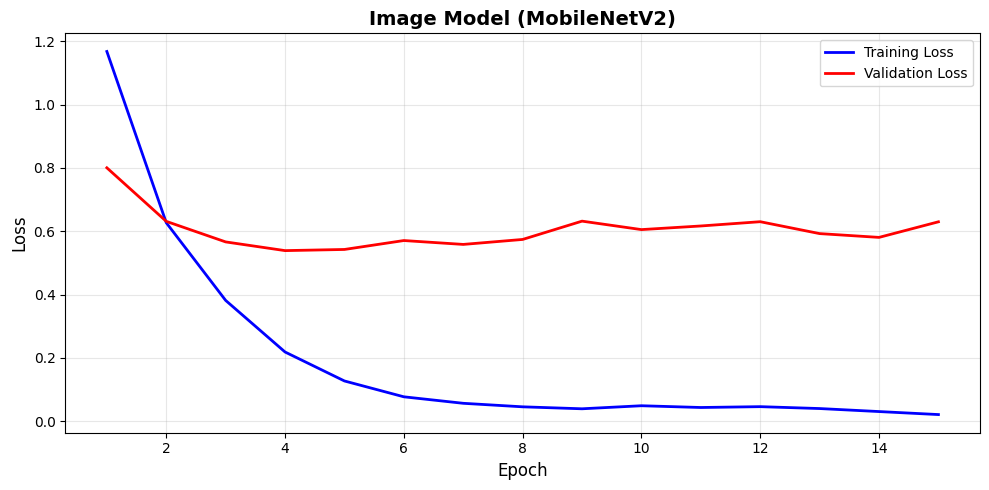

In [87]:
plot_training_curves(train_losses, test_losses, title="Image Model (MobileNetV2)")

# Text-Only Model (DistilBERT)


## Load DistilBERT


In [45]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
distilbert.eval()
distilbert.to(DEVICE)

TEXT_DIM = 768

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Text Dataset


In [68]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=32):
        self.texts = df["filtered_text"].tolist()
        self.labels = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return (
            enc["input_ids"].squeeze(0),      # CPU
            enc["attention_mask"].squeeze(0), # CPU
            self.labels[idx]
        )


## Text Classifier


In [69]:
class TextModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(TEXT_DIM, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.fc(x)

## Train Text-Only Model


In [81]:
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "distilbert_text_model.pth")
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

train_loader = DataLoader(TextDataset(train_df, tokenizer), batch_size=64, shuffle=True)
val_loader = DataLoader(TextDataset(val_df, tokenizer), batch_size=64,)

text_model = TextModel(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(text_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scaler = torch.amp.GradScaler(DEVICE)

start_epoch = 0

train_losses, test_losses = [], []

if os.path.exists(CHECKPOINT_PATH):
    print("Text model checkpoint found. Loading weights...")

    ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    text_model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    train_losses = ckpt.get("train_losses", [])
    test_losses = ckpt.get("test_losses", [])
    start_epoch = ckpt["epoch"]
else:
    print("No checkpoint found. Starting training...")

for epoch in range(start_epoch, EPOCHS):
    train_loss, acc = train_epoch(
        text_model, train_loader, optimizer, scaler, criterion, DEVICE, mode="text"
    )
    train_losses.append(train_loss)

    test_loss, val_acc = eval_epoch(text_model, val_loader, criterion, DEVICE, mode="text")
    test_losses.append(test_loss)

    print(
        f"[Text] Epoch {epoch+1} | Loss {train_loss:.3f} | Train {acc:.3f} | Val {val_acc:.3f}"
    )

    save_model(
        text_model,
        optimizer,
        epoch + 1,
        NUM_CLASSES,
        le,
        CHECKPOINT_PATH,
        train_losses,
        test_losses,
        text_model_str="distilbert-base-uncased",
    )

No checkpoint found. Starting training...
[Text] Epoch 1 | Loss 1.443 | Train 0.529 | Val 0.607
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 2 | Loss 1.150 | Train 0.615 | Val 0.622
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 3 | Loss 1.067 | Train 0.648 | Val 0.668
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 4 | Loss 1.015 | Train 0.660 | Val 0.669
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 5 | Loss 0.968 | Train 0.675 | Val 0.684
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 6 | Loss 0.939 | Train 0.686 | Val 0.692
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 7 | Loss 0.906 | Train 0.697 | Val 0.703
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 8 | Loss 0.881 | Train 0.709 | Val 0.706
Saved model to checkpoints/distilbert_text_model.pth
[Text] Epoch 9 | Loss 0.855 | Train 0.713 | Val 0.713
Saved model to checkpoints/distilbert_text_model

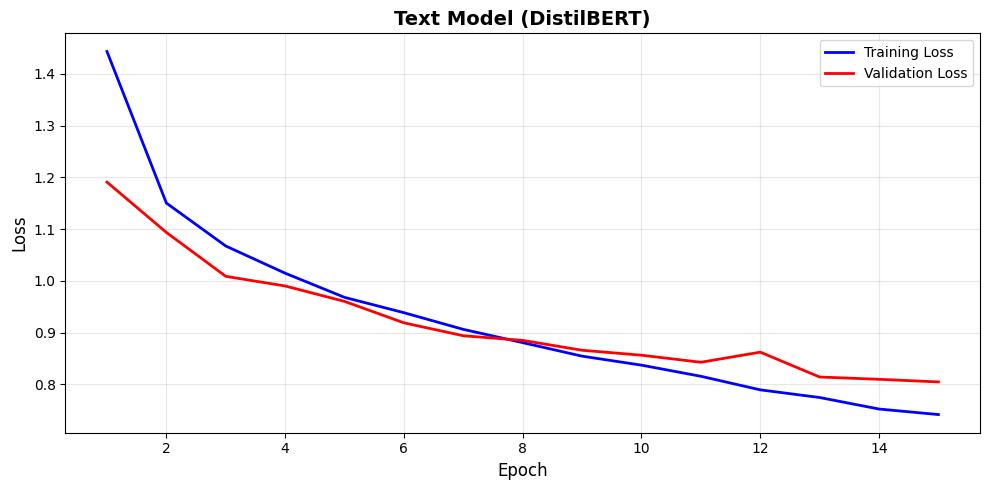

In [89]:
plot_training_curves(train_losses, test_losses, title="Text Model (DistilBERT)")